In [1]:
# import sys
# sys.path.append('/home/nicholasjesperson/Documents/School/Comp4780/Data_Augmentation/Data Augmentation/paper/AugmenTRAJ')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from ptrail.core.Datasets import Datasets
from ptrail.preprocessing.filters import Filters
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics

from src.augmentation.augment import Augmentation
from src.selection.select import Selection
from src.utils.alter import Alter

from matplotlib.colors import ListedColormap
from random import Random

In [3]:
def trajectoryAugumentationProcedure(trajs, seed, n, k, pradius, class_name, selection, augment):
    myRandom = Random(seed * (n * k * pradius))

    # Select the trajectories and remove duplicates from original dataset.
    if selection == 'random':
        splits = Selection.select_randomly(trajs, myRandom, .2)
    elif selection == 'fewest':
        splits = Selection.select_traj_with_fewest(trajs, myRandom, .2)
    else:
        splits = Selection.select_representative_trajectories(trajs, class_name)
    paramTestingDataSet = Filters.remove_duplicates(dataframe=trajs)

    trainDataParm = paramTestingDataSet.loc[paramTestingDataSet.traj_id.isin(splits["train"]) == True].dropna()
    testDataParm = paramTestingDataSet.loc[paramTestingDataSet.traj_id.isin(splits["test"]) == True].dropna()
    testData = PTRAILDataFrame(data_set=testDataParm,
                               latitude='lat',
                               longitude='lon',
                               datetime='DateTime',
                               traj_id='traj_id')


    noiseTraj = trainDataParm.traj_id.unique()
    sampledTraj = myRandom.choices(sorted(noiseTraj), k=math.floor(n * len(noiseTraj)))
    for traj in sampledTraj:
        trajToChange = trainDataParm.loc[trainDataParm.traj_id == traj]

        #Trajectory must be changed
        if augment == 'on':
            trajChanged = Augmentation.augment_trajectories_with_randomly_generated_points(trajToChange, pradius,
                                                                                         k, 100, myRandom, 'on')
        elif augment == 'in':
            trajChanged = Augmentation.augment_trajectories_with_randomly_generated_points(trajToChange, pradius,
                                                                                          k, 100, myRandom, 'in')
        else:
            trajChanged = Augmentation.augment_trajectories_with_interpolation(trajToChange, 3600*4, 'linear')
        trainDataParm = pd.concat([trainDataParm, trajChanged], ignore_index = True)

    trainDataNoise = PTRAILDataFrame(data_set=trainDataParm,
                                            datetime='DateTime',
                                            traj_id='traj_id',
                                            latitude='lat',
                                            longitude='lon')

    statsTestParm = Statistics.generate_kinematic_stats(dataframe=testData, target_col_name=class_name)
    pivotedStatsTestParm = Statistics.pivot_stats_df(dataframe=statsTestParm, target_col_name=class_name)
    testData = pivotedStatsTestParm.loc[:,~pivotedStatsTestParm.columns.duplicated()]

    statsTrainNoiseParm = Statistics.generate_kinematic_stats(dataframe=trainDataNoise, target_col_name=class_name)
    pivotedStatsTrainNoiseParm = Statistics.pivot_stats_df(dataframe=statsTrainNoiseParm, target_col_name=class_name)
    pivotedStatsTrainNoise = pivotedStatsTrainNoiseParm.loc[:, ~pivotedStatsTrainNoiseParm.columns.duplicated()]
    trainDataNoise=pivotedStatsTrainNoise.dropna()

    return testData, trainDataNoise

In [4]:
# Load the hurricane dataset.
original_hurricane = Datasets.load_starkey()
stats = Statistics.generate_kinematic_stats(original_hurricane, "Species")
pivoted_original_stats = Statistics.pivot_stats_df(stats, "Species")

# Read the results from the file.
all_hurricane_results = pd.read_csv('./FinalStarkeyResults.csv', sep=',', header=None)
all_hurricane_results.columns = ['seed', 'n_val', 'k_val', 'rad_val', 'traj_selection_method', 'augmentation_method', 'f1_score']
all_hurricane_results.sort_values(by='f1_score', ascending=False, ignore_index=True, inplace=True)
best_starkey_result_set = all_hurricane_results.iloc[0, :].tolist()

------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 253
Number of points in the data: 287136
Dataset time range: 1196 days 22:51:45
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (45.18896978643169, -118.61020848239596, 45.314545642992, -118.50455596234036)

---------------------------------------------------------------------


In [5]:
testData, trainingData = trajectoryAugumentationProcedure(original_hurricane, best_starkey_result_set[0],
                                                        best_starkey_result_set[1], best_starkey_result_set[2],
                                                        best_starkey_result_set[3], 'Species',
                                                        best_starkey_result_set[4], best_starkey_result_set[5])

In [6]:
def plot_original_dataset(ax, target_col):
    ax[0].set_title("1. Starkey data set")
    scaler = MinMaxScaler(feature_range=(0, 1))
    ogX = scaler.fit_transform(pivoted_original_stats.drop(columns=[target_col]))
    ogY = pivoted_original_stats[target_col]
    # Plot all points of the dataset.
    pca = PCA(n_components=2)
    Xt = pca.fit_transform(X=ogX)
    h = 0.05
    x_min, x_max = Xt[:, 0].min() - .5, Xt[:, 0].max() + .5
    y_min, y_max = Xt[:, 1].min() - .5, Xt[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    sns.scatterplot(x=Xt[:, 0], y=Xt[:, 1],
                      hue=ogY, ax=ax[0], palette=['red', 'yellow', 'royalblue'])
    ax[0].set_xlim(xx.min(), xx.max())
    ax[0].set_ylim(yy.min(), yy.max())
    handles, labels  =  ax[0].get_legend_handles_labels()
    ax[0].legend(handles, ['Elk', 'Deer', 'Cattle'], loc='lower right')

In [7]:
seed = best_starkey_result_set[0]

def plot_contours_original(dataset, ax, title, target_col, i):
    model = RandomForestClassifier(random_state=best_starkey_result_set[0])
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(dataset.drop(columns=[target_col]))
    Y = dataset[target_col]

    # Perform PCA on our df and extract 2 components for visualization purposes.
    pca = PCA(n_components=2)
    Xt = pca.fit_transform(X=X)
    X_train, X_test, y_train, y_test = train_test_split(Xt, Y, test_size=0.2, random_state=seed)

    h = 0.05
    x_min, x_max = Xt[:, 0].min() - .5, Xt[:, 0].max() + .5
    y_min, y_max = Xt[:, 1].min() - .5, Xt[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    # cm_bright = ListedColormap(["#FF0000", "#FFFF00", "#00FF00"])
    cm = plt.cm.RdYlBu

    # for i, name, model in zip(range(1, len(ax)), names, models):
    model.fit(X_train, y_train)
    hue = model.predict(X_test)
    score = f1_score(y_test, hue, average='weighted')
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Reshape the array and then plot the contour plot.
    Z = Z.reshape(xx.shape)
    ax[i].contourf(xx, yy, Z, cmap=cm, alpha=0.75)

    # Now, we plot the points onto the contour and then map their
    # colors according to the regions.
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1],
                  hue=y_test, ax=ax[i], palette=['red', 'yellow', 'royalblue'])

    ax[i].set_title(f'{title}, F-Score: {round(score, 2)}')
    ax[i].get_legend().remove()
    # plt.show()

In [8]:
def plot_contour_augmented(testData, trainingData, ax, title, i, class_name, seed):
    model = RandomForestClassifier(random_state=best_starkey_result_set[0])
    scaler = MinMaxScaler(feature_range=(0, 1))
    pca = PCA(n_components=2)
    X = pd.concat([trainingData.drop(columns=class_name), testData.drop(columns=class_name), ])
    Y = pd.concat([trainingData[class_name], testData[class_name]])
    # testX = testData.drop(columns=class_name)
    # testY = testData[class_name].to_numpy()
    #
    # trainX = trainingData.drop(columns=class_name)
    # trainY = trainingData[class_name].to_numpy()

    
    # Get the Xt ready.
    # Xt = pd.concat([trainX, testX])
    Xt = scaler.fit_transform(X)
    Xt = pca.fit_transform(Xt)


    # Perform PCA on our df and extract 2 components for visualization purposes.
    # testX = pca.fit_transform(X=testX)
    # trainX = pca.fit_transform(X=trainX)
    X_train, X_test, y_train, y_test = train_test_split(Xt, Y, test_size=0.2, random_state=seed)
    # X_train, X_test, y_train, y_test = scaler.fit_transform(trainX), scaler.fit_transform(testX), trainY, testY

    h = 0.05
    x_min, x_max = Xt[:, 0].min() - .5, Xt[:, 0].max() + .5
    y_min, y_max = Xt[:, 1].min() - .5, Xt[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    # cm_bright = ListedColormap(["#FF0000", "#FFFF00", "#00FF00"])
    cm = plt.cm.RdYlBu

    # for i, name, model in zip(range(1, len(ax)), names, models):
    model.fit(X_train, y_train)
    hue = model.predict(X_test)
    score = f1_score(y_test, hue, average='weighted')
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Reshape the array and then plot the contour plot.
    Z = Z.reshape(xx.shape)
    ax[i].contourf(xx, yy, Z, cmap=cm, alpha=0.75)

    # Now, we plot the points onto the contour and then map their
    # colors according to the regions.
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1],
                  hue=y_test, ax=ax[i], palette=['red', 'yellow', 'royalblue'])

    ax[i].set_title(f'{title}, F-Score: {round(score, 2)}')
    ax[i].get_legend().remove()

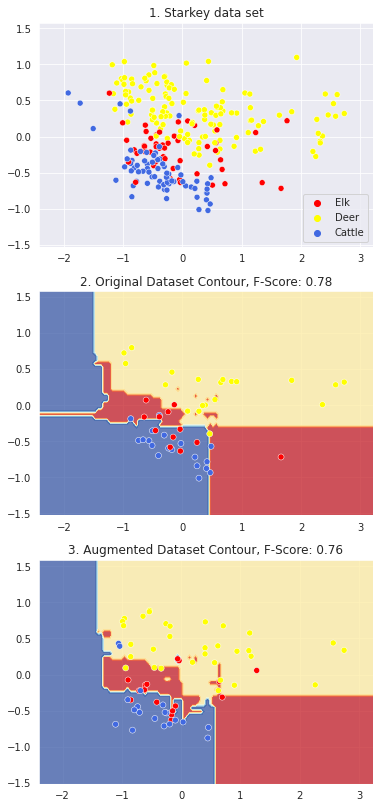

In [9]:
fig2, ax = plt.subplots(3, 1, figsize=(6, 14))
fig2.set_facecolor('white')
ax=ax.flatten()

# Plot the original dataset.
plot_original_dataset(ax, 'Species')

# Plot contour for the original dataset.
plot_contours_original(pivoted_original_stats, ax, "2. Original Dataset Contour", "Species", 1)

# Plot contour for augmented dataset.
plot_contour_augmented(testData, trainingData,
                        ax, "3. Augmented Dataset Contour", 2, "Species", best_starkey_result_set[0])

In [10]:
model = RandomForestClassifier()

model.fit(trainingData.drop(columns=['Species']), trainingData['Species'])
f1_score(model.predict(testData.drop(columns=['Species'])), testData['Species'], average='weighted')

0.9802962962962962